In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
# from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier # for features importance

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227

In [27]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, plot_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [28]:
try:
  import tensorflow as tf
  from bayes_opt import BayesianOptimization
  import yfinance as yf
except:
  !pip install tensorflow bayesian-optimization yfinance
  import tensorflow as tf
  from bayes_opt import BayesianOptimization
  import yfinance as yf

In [29]:
from tensorflow.python import keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model

In [30]:
np.random.seed(66)

In [31]:
try:
  data = pd.read_csv('AAPL.csv')
except:
  from pandas_datareader import data as pdr
  yf.pdr_override()

  # download dataframe
  data = pdr.get_data_yahoo("AAPL", start="2017-01-01", end="2022-12-30")
  data.to_csv('AAPL.csv')

In [32]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989267,115127600
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,26.959057,84472400
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.096157,88774400
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.398232,127007600
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.649185,134247600


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1509 non-null   object 
 1   Open       1509 non-null   float64
 2   High       1509 non-null   float64
 3   Low        1509 non-null   float64
 4   Close      1509 non-null   float64
 5   Adj Close  1509 non-null   float64
 6   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.6+ KB


In [34]:
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


In [35]:
# convert date field from string to Date format
data['Date'] = pd.to_datetime(data.Date)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989267,115127600
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,26.959057,84472400
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.096157,88774400
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.398232,127007600
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.649185,134247600


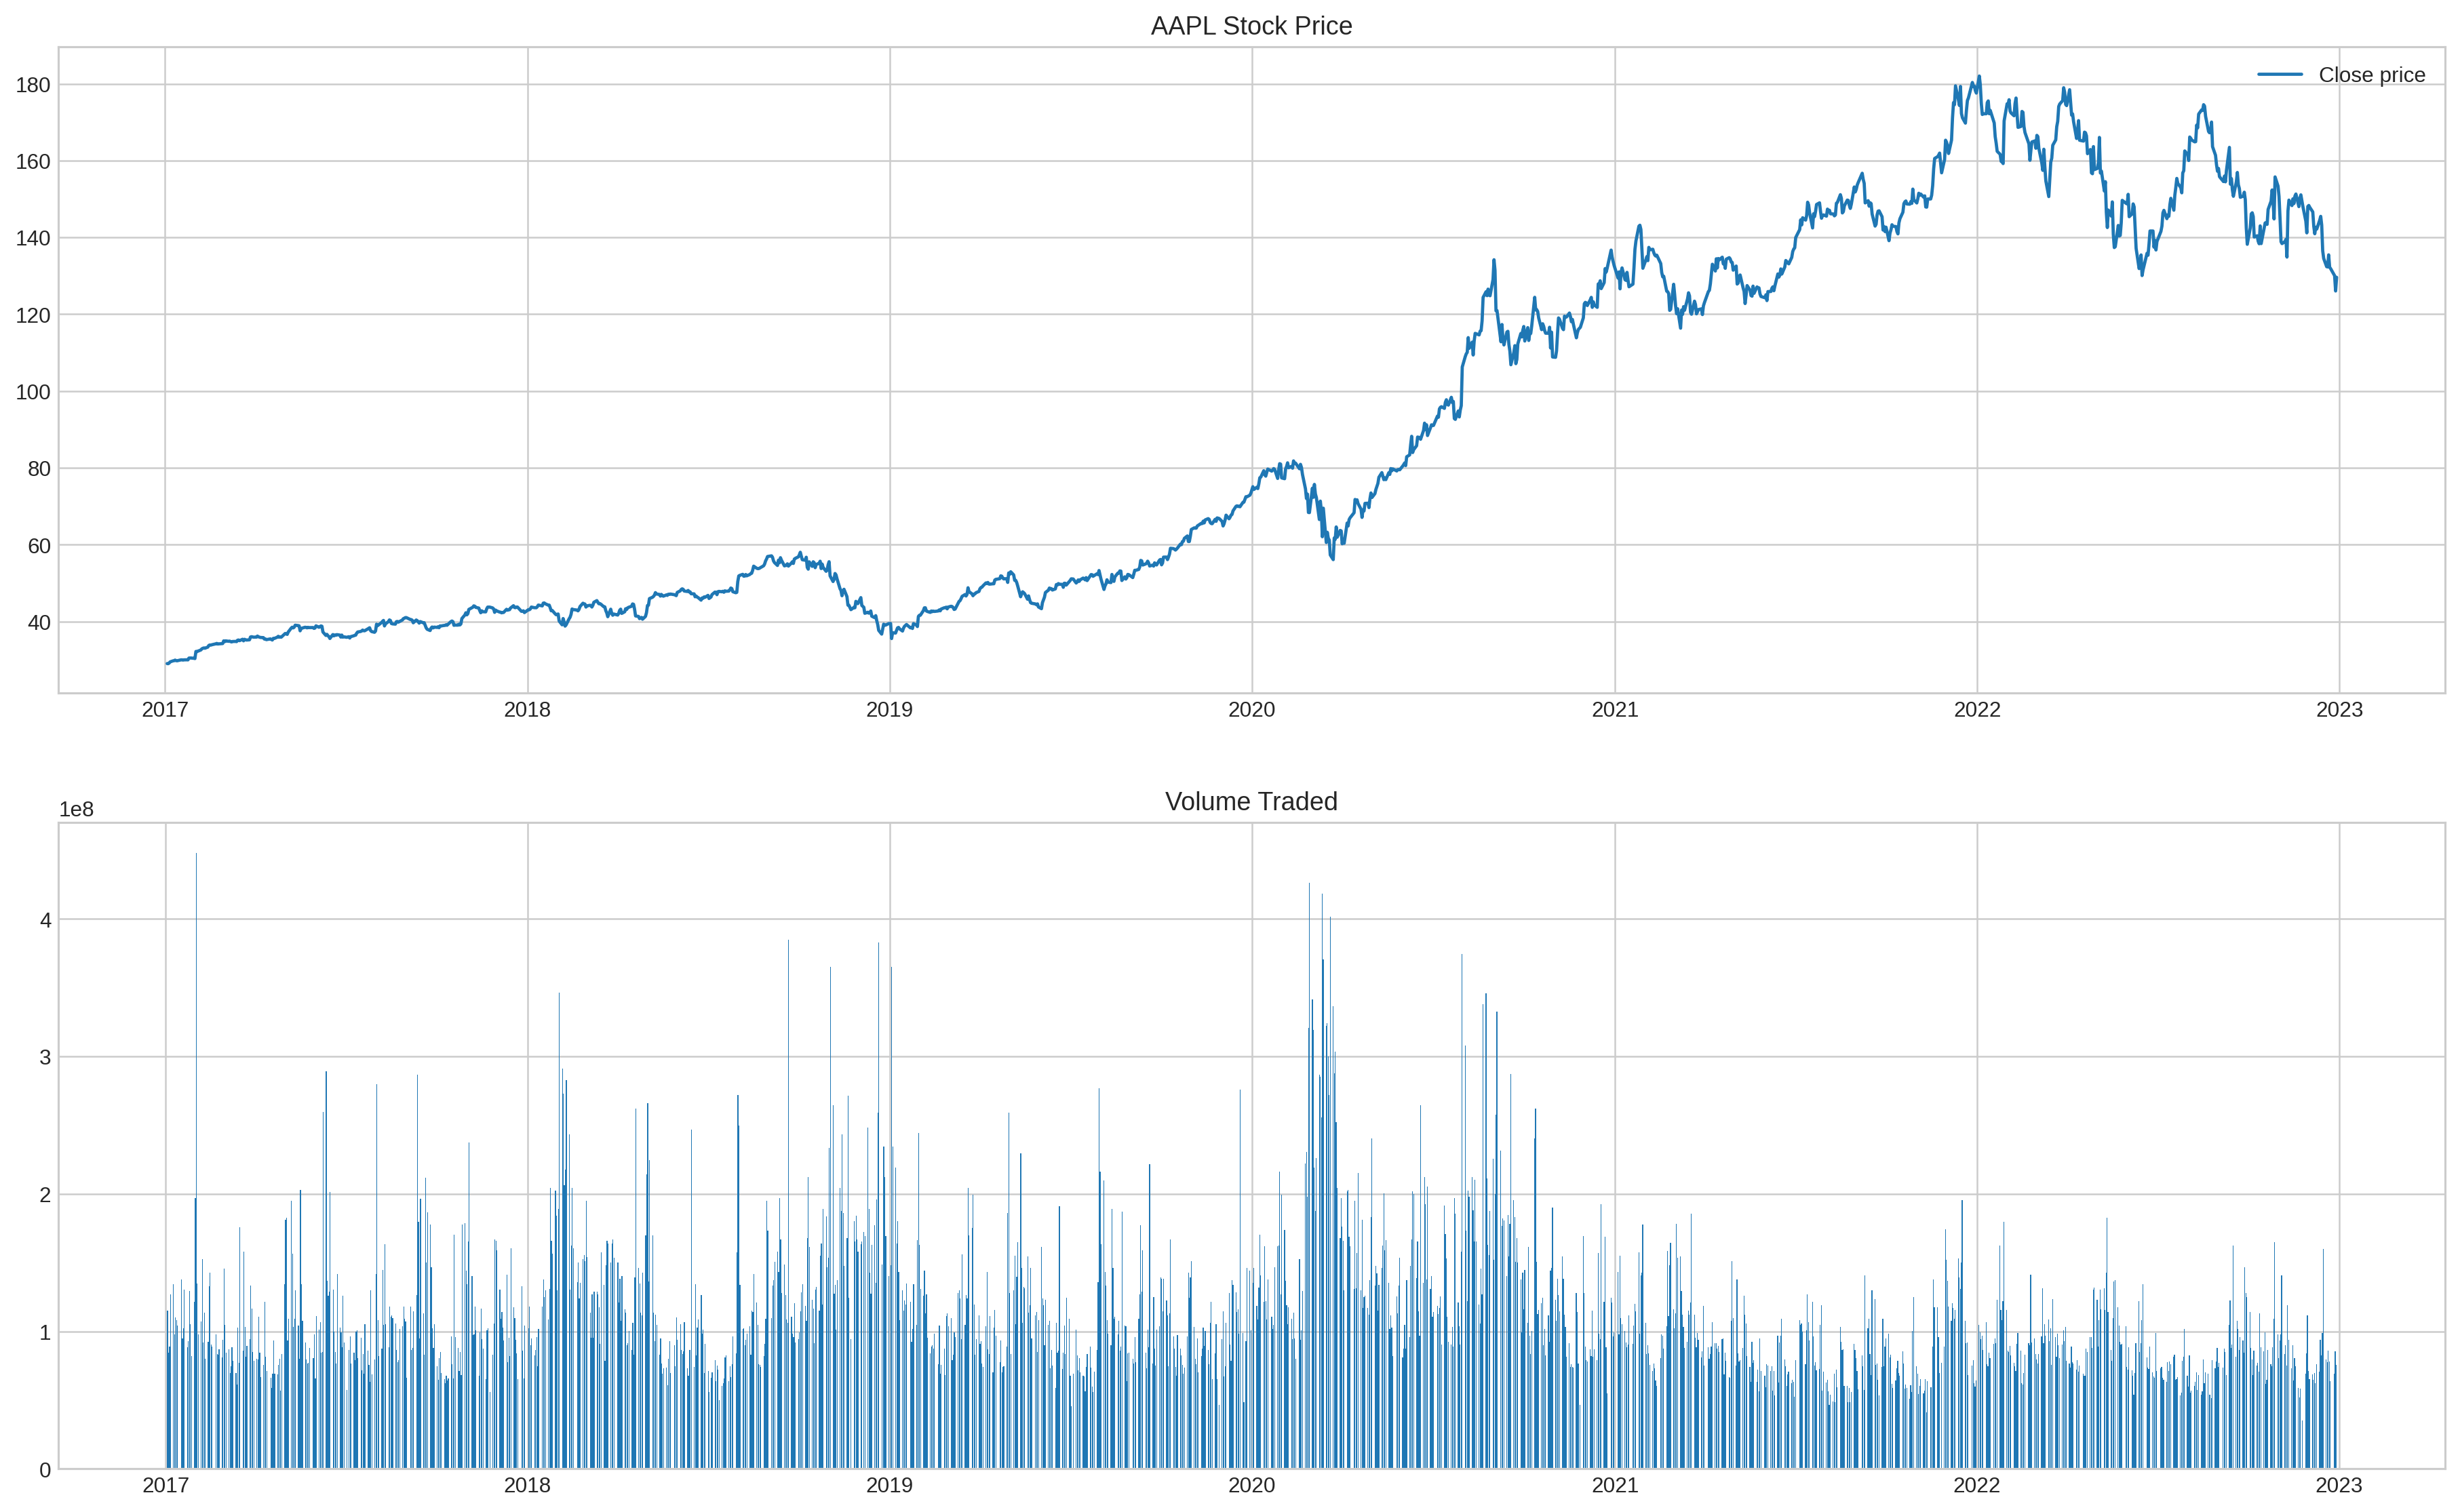

In [63]:
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.title('AAPL Stock Price')
plt.plot(data.Close,label='Close price')
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Volume Traded')
plt.bar(x=data.index,height=data['Volume'])
plt.show()

In [36]:
monthwise= data.groupby(data['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,81.001004,81.010164
February,82.868684,82.908245
March,80.620151,80.718590
April,82.615203,82.581870
May,79.552540,79.624862
June,81.655430,81.757617
July,87.068988,87.405714
August,95.625187,95.745858
September,96.073156,95.721208


In [37]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the 'Open' price bar trace
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='Stock Open Price',
    marker_color='crimson',
    text=monthwise['Open'].round(2),  # Labels for 'Open' price bars
    textposition='auto'  # Automatically position the labels
))

# Add the 'Close' price bar trace
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='Stock Close Price',
    marker_color='teal',
    text=monthwise['Close'].round(2),  # Labels for 'Close' price bars
    textposition='auto'  # Automatically position the labels
))

# Update layout and show the figure
fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparison between Stock open and close price',
                  yaxis_title='Price',
                  xaxis_title='Month')
fig.show()


In [38]:
def baseline_model(stock_data):
  # Generate random binary predictions
  baseline_predictions = np.random.randint(0, 2, len(stock_data))

  # Shift stock data to align with predictions
  stock_direction = np.where(stock_data['Close'].shift(-1) > stock_data['Close'], 1, 0)

  # Calculate accuracy
  accuracy = accuracy_score(stock_direction[:-1], baseline_predictions[:-1])

  return accuracy

accuracy = baseline_model(data)
print('Baseline model accuracy: {:.1f}%'.format(accuracy * 100))

Baseline model accuracy: 49.1%


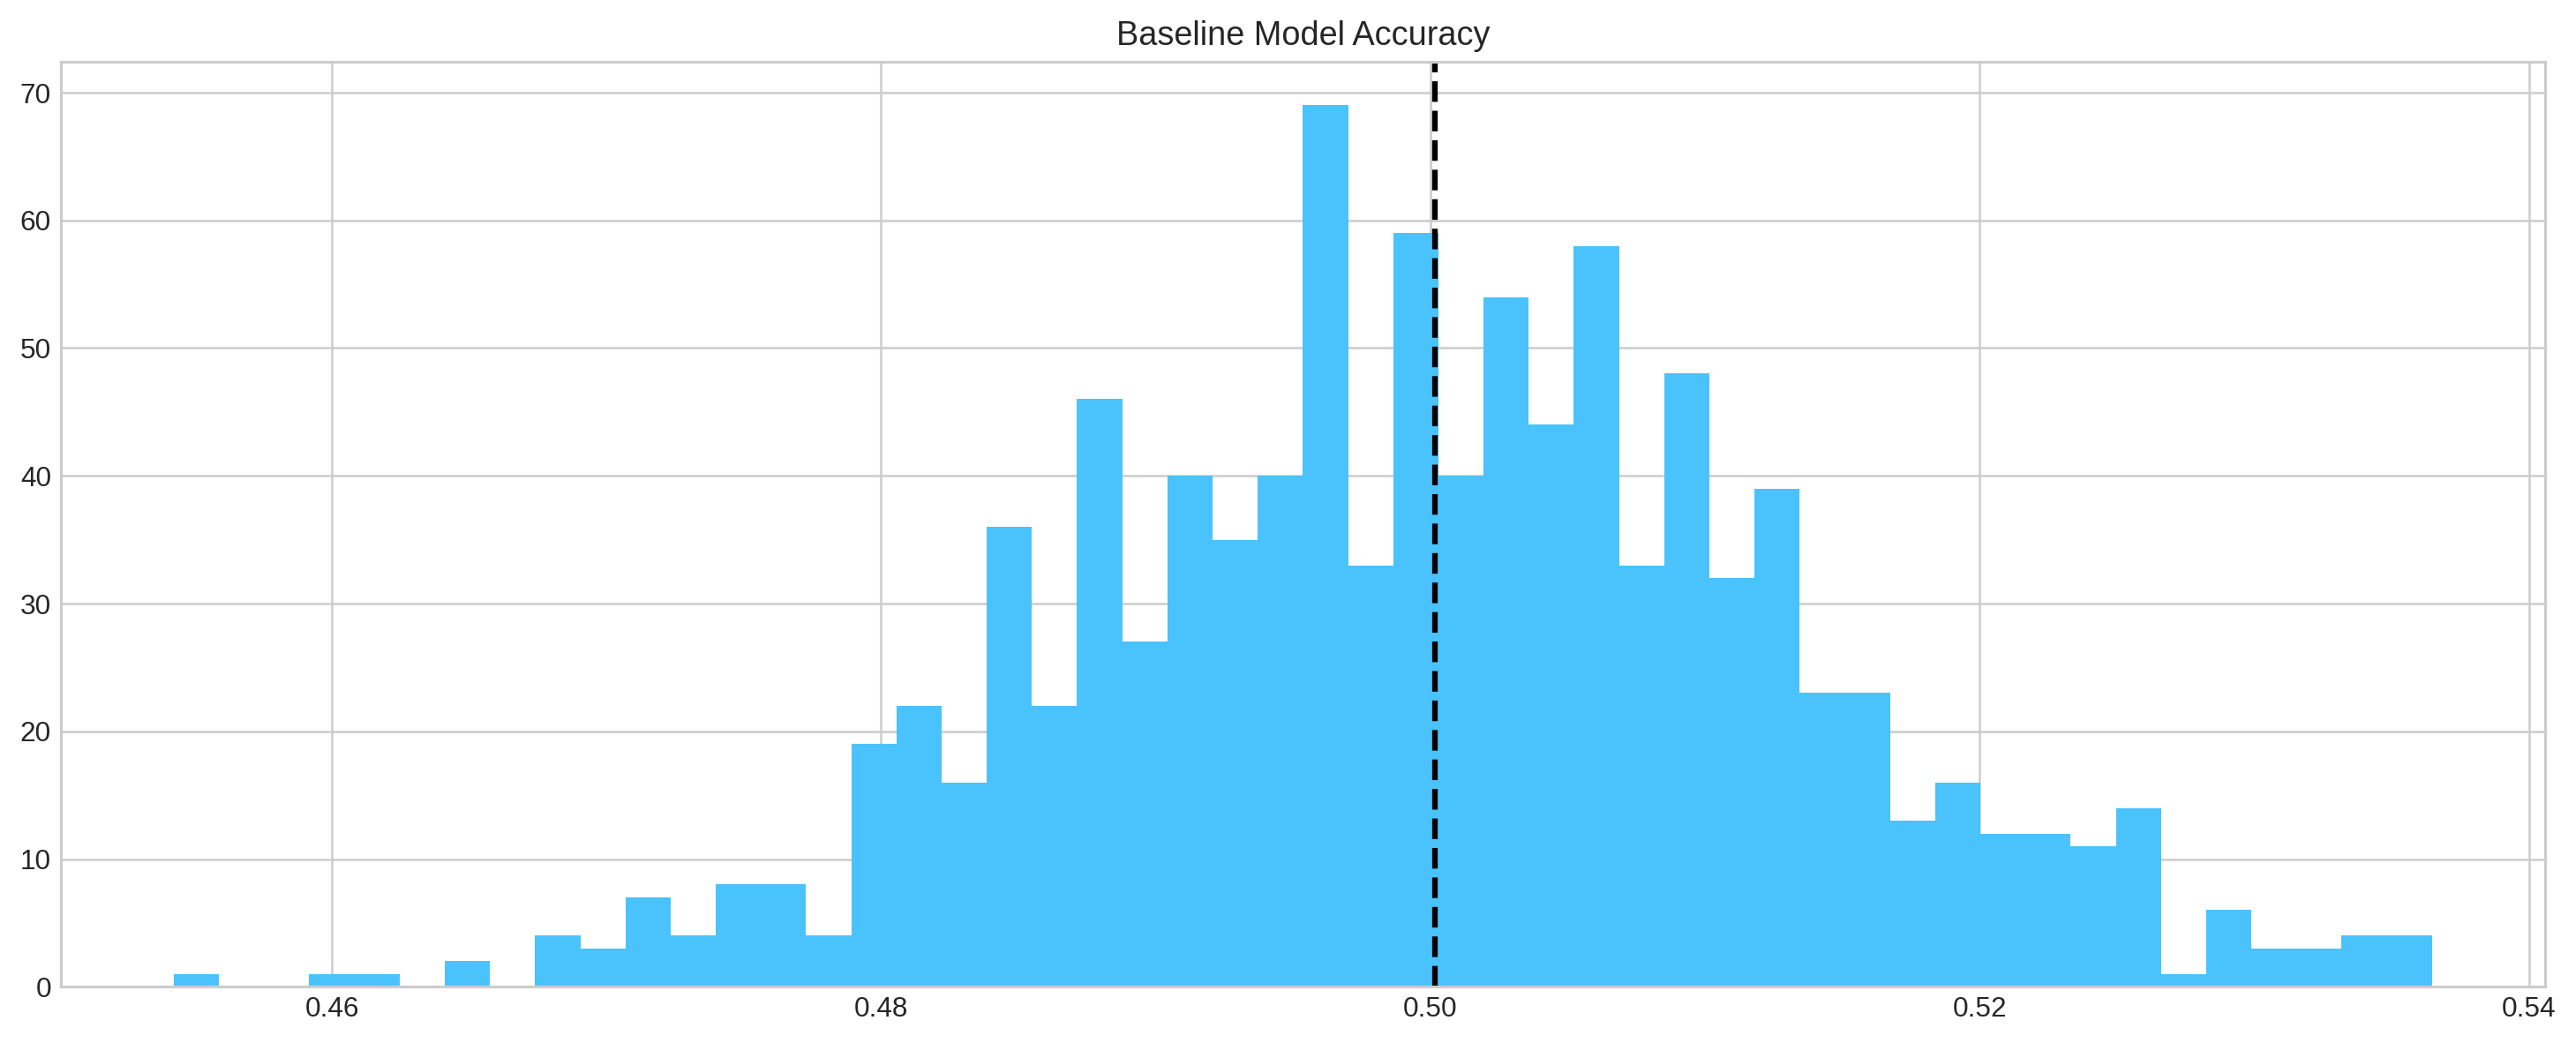

In [39]:
base_preds = []
for i in range(1000):
  base_preds.append(baseline_model(data))

plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy')
plt.axvline(np.array(base_preds).mean(), c='k', ls='--', lw=2)
plt.show()

In [40]:
data.Date= pd.to_datetime(data.Date)
data =data.set_index('Date')

In [41]:
from statsmodels.tsa.stattools import adfuller

df = data['Close']
result = adfuller(df)
print("1. ADF : ",result[0])
print("2. P-Value : ", result[1])
print("3. Num Of Lags : ", result[2])
print("4. Num Of Observations Used For ADF Regression:", result[3])
print("5. Critical Values :")
for key, val in result[4].items():
  print("\t",key, ": ", val)

1. ADF :  -1.0168702313048341
2. P-Value :  0.7470616507109579
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 1497
5. Critical Values :
	 1% :  -3.434725783926551
	 5% :  -2.863472629385615
	 10% :  -2.567798908763865


In [42]:
!pip install pmdarima

In [43]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df,
                 test = "adf")
print("d value:", d_value)

d value: 1


In [44]:
from pmdarima import auto_arima

In [45]:
x_train= df[:-150]
x_test = df[-150:]
print(len(x_train),len(x_test))

1359 150


In [46]:
stepwise_fit = auto_arima(df,
                          trace=True,
                          suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6431.223, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6433.360, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6430.324, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6430.006, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6432.972, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6430.329, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6430.685, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6432.235, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6429.832, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6430.335, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6430.629, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6430.124, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6432.242, Time=1.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.408 seconds
                      

In [47]:
model = sm.tsa.arima.ARIMA(df, order=(0,1,1))

In [48]:
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1509
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3212.916
Date:                Tue, 23 Apr 2024   AIC                           6429.832
Time:                        04:47:01   BIC                           6440.469
Sample:                             0   HQIC                          6433.794
                               - 1509                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0602      0.017     -3.632      0.000      -0.093      -0.028
sigma2         4.1507      0.083     49.787      0.000       3.987       4.314
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1454.60
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              17.25   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
start=len(x_train)
end=len(x_train)+len(x_test)-1
pred = model.predict(start=start,end=end)
pred

Date
2022-05-26    140.519135
2022-05-27    143.583664
2022-05-31    149.275351
2022-06-01    148.866209
2022-06-02    148.719412
                 ...    
2022-12-22    135.261090
2022-12-23    132.412496
2022-12-27    131.893266
2022-12-28    130.142185
2022-12-29    126.286991
Name: predicted_mean, Length: 150, dtype: float64

In [50]:
s = pd.Series(pred, index =df.index[-150:])
s

Date
2022-05-26    140.519135
2022-05-27    143.583664
2022-05-31    149.275351
2022-06-01    148.866209
2022-06-02    148.719412
                 ...    
2022-12-22    135.261090
2022-12-23    132.412496
2022-12-27    131.893266
2022-12-28    130.142185
2022-12-29    126.286991
Name: predicted_mean, Length: 150, dtype: float64

<Axes: xlabel='Date'>

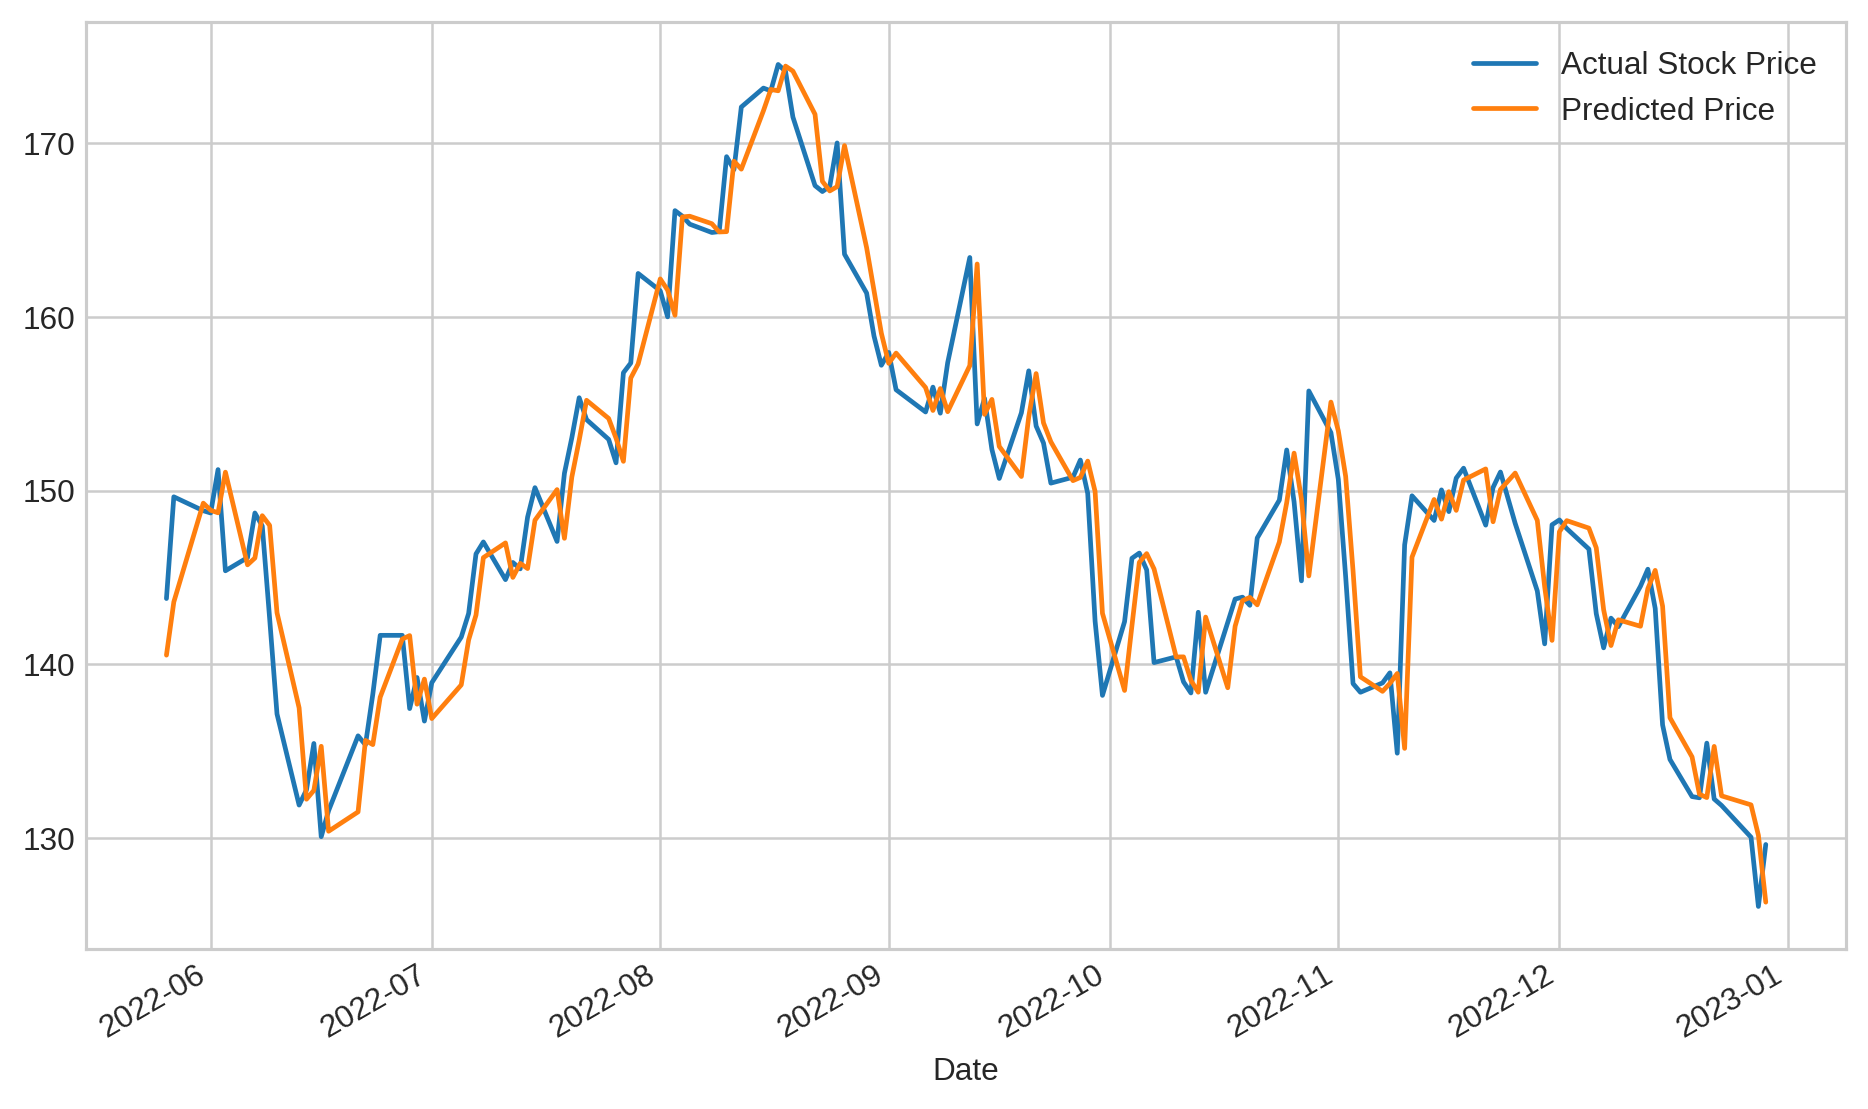

In [51]:
plt.figure(figsize=(10,6))
df[-150:].plot(label='Actual Stock Price', legend=True)
s.plot(label='Predicted Price', legend=True,)

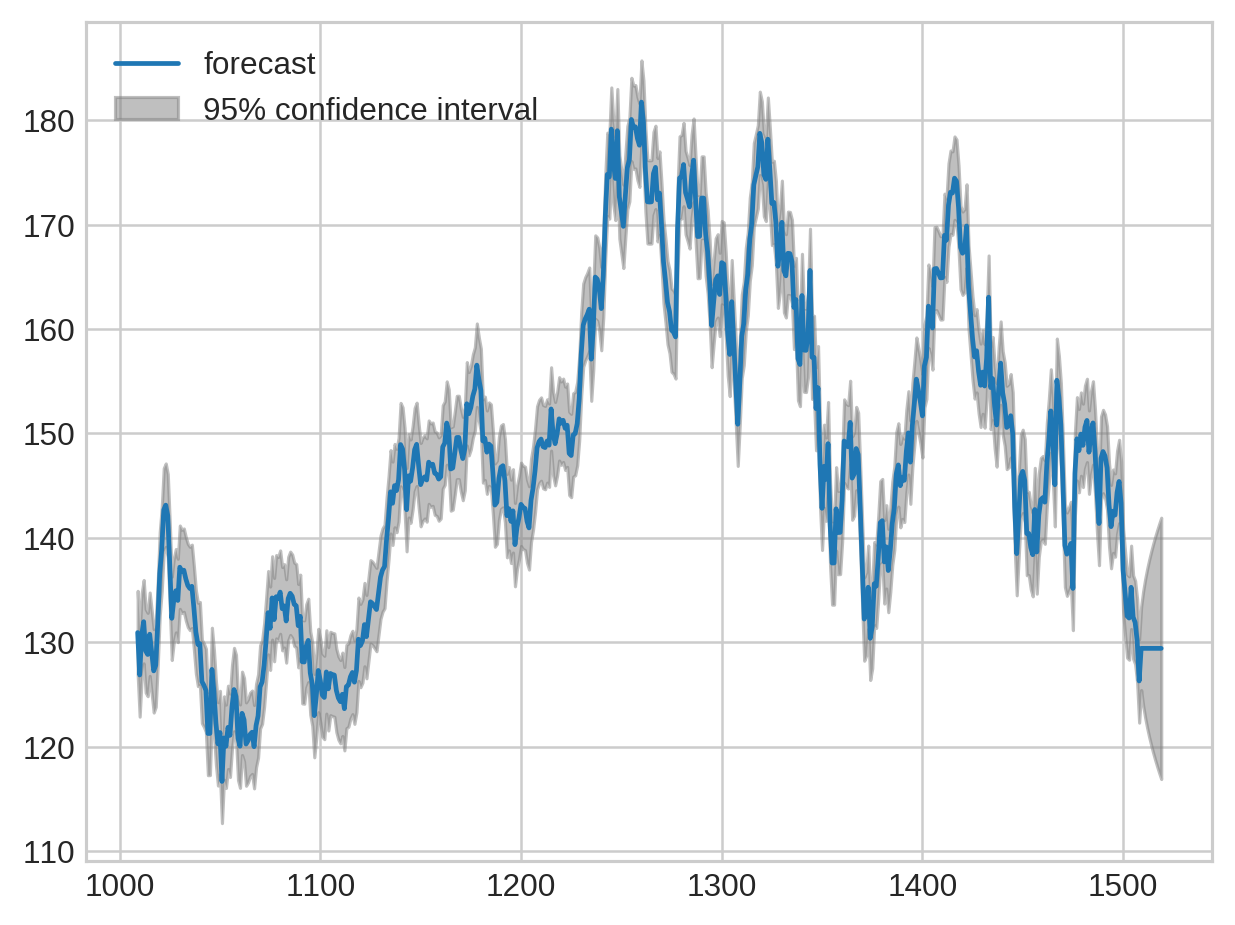

In [52]:
plot_predict(model, start = len(df)-500, end = len(df)+10, dynamic = False);

In [53]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(x_test,pred))

3.3332565726954164

In [54]:
from sklearn.metrics import r2_score
r2_score(x_test,pred)

0.9007822305648584

In [55]:
pred_future = model.predict(start=end,end=end+10)
pred_future

1508    126.286991
1509    129.409924
1510    129.409924
1511    129.409924
1512    129.409924
1513    129.409924
1514    129.409924
1515    129.409924
1516    129.409924
1517    129.409924
1518    129.409924
Name: predicted_mean, dtype: float64

In [56]:
import datetime
start_date = datetime.datetime(2022,12,20)
dates = [start_date + datetime.timedelta(days=idx) for idx in range(11)]

In [57]:
dates

[datetime.datetime(2022, 12, 20, 0, 0),
 datetime.datetime(2022, 12, 21, 0, 0),
 datetime.datetime(2022, 12, 22, 0, 0),
 datetime.datetime(2022, 12, 23, 0, 0),
 datetime.datetime(2022, 12, 24, 0, 0),
 datetime.datetime(2022, 12, 25, 0, 0),
 datetime.datetime(2022, 12, 26, 0, 0),
 datetime.datetime(2022, 12, 27, 0, 0),
 datetime.datetime(2022, 12, 28, 0, 0),
 datetime.datetime(2022, 12, 29, 0, 0),
 datetime.datetime(2022, 12, 30, 0, 0)]

In [58]:
pred_future2 = pd.Series(pred_future.values, index = dates)
pred_future2

2022-12-20    126.286991
2022-12-21    129.409924
2022-12-22    129.409924
2022-12-23    129.409924
2022-12-24    129.409924
2022-12-25    129.409924
2022-12-26    129.409924
2022-12-27    129.409924
2022-12-28    129.409924
2022-12-29    129.409924
2022-12-30    129.409924
dtype: float64

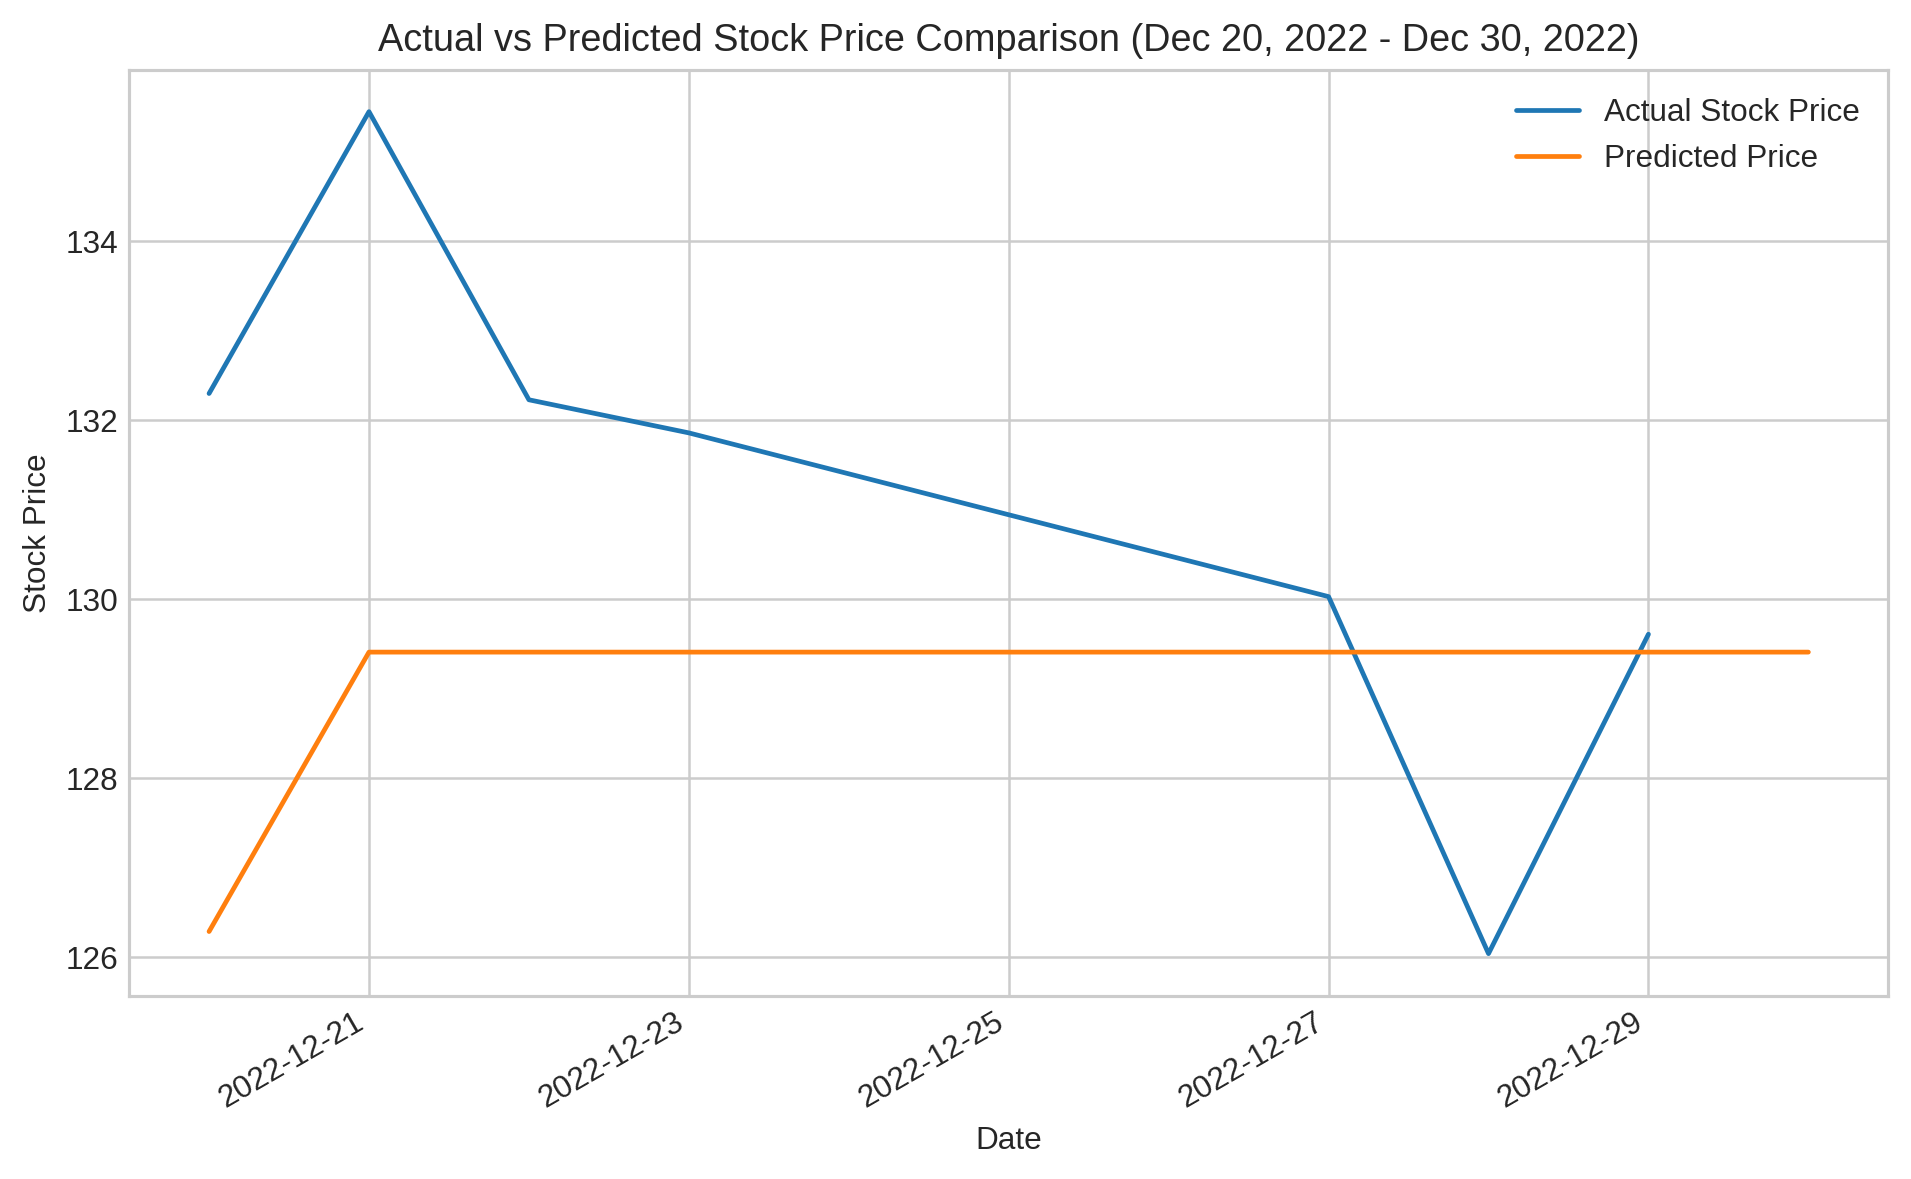

In [59]:
# Filter the original DataFrame 'df' for the period from December 20, 2022, to December 30, 2022
start_date = pd.to_datetime('2022-12-20')
end_date = pd.to_datetime('2022-12-30')
df_comparison = df[start_date:end_date]

# Plot the actual stock price and the predicted values for this period
plt.figure(figsize=(10, 6))
df_comparison.plot(label='Actual Stock Price', legend=True)
pred_future2.plot(label='Predicted Price', legend=True)
plt.title('Actual vs Predicted Stock Price Comparison (Dec 20, 2022 - Dec 30, 2022)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()